In [44]:
import pickle
import pandas as pd
from features.pkl import PickleFeatureWriter
from datasets.pickle_dataset import MultiPickleDataset
import os
from pathlib import Path
from models.esvs import V_MTRN, N_MTRN
from torch.optim import Adam
import torch
from frame_sampling import RandomSampler
from scripts.train_mtrn import train_test_loader
from systems import EpicActionRecogintionShapleyClassifier
from livelossplot import PlotLosses
import numpy as np
from torchvideo.samplers import frame_idx_to_list

In [11]:
p = Path('/mnt/storage/home/jb18789/scratch/datasets/epic-100/video_id_features/p01_features.pkl')

# with open(p, 'rb') as f:
#     df = pickle.load(f)
# id = 'P01'
# p.parent / f'{id}.pkl'\

In [5]:
os.path.getsize(p)

1071940023

In [8]:
def no_collate(args):
    return args

In [9]:
models = [V_MTRN(frame_count=i) for i in range(1,9)]
optims = [Adam(m.parameters(), lr=3e-4) for m in models]
frame_samplers = [RandomSampler(frame_count=m.frame_count, snippet_length=1,test=False) for m in models]

In [20]:
trainloader, testloader = train_test_loader(MultiPickleDataset(p), 64, 0.3)

In [21]:
classifier = EpicActionRecogintionShapleyClassifier(
    models[3],
    torch.device('cpu'),
    optims[3],
    frame_samplers[3],
    trainloader,
    testloader,
    'verb'
)


Classifier, model: <class 'models.esvs.V_MTRN'>, type: verb, frames: 4


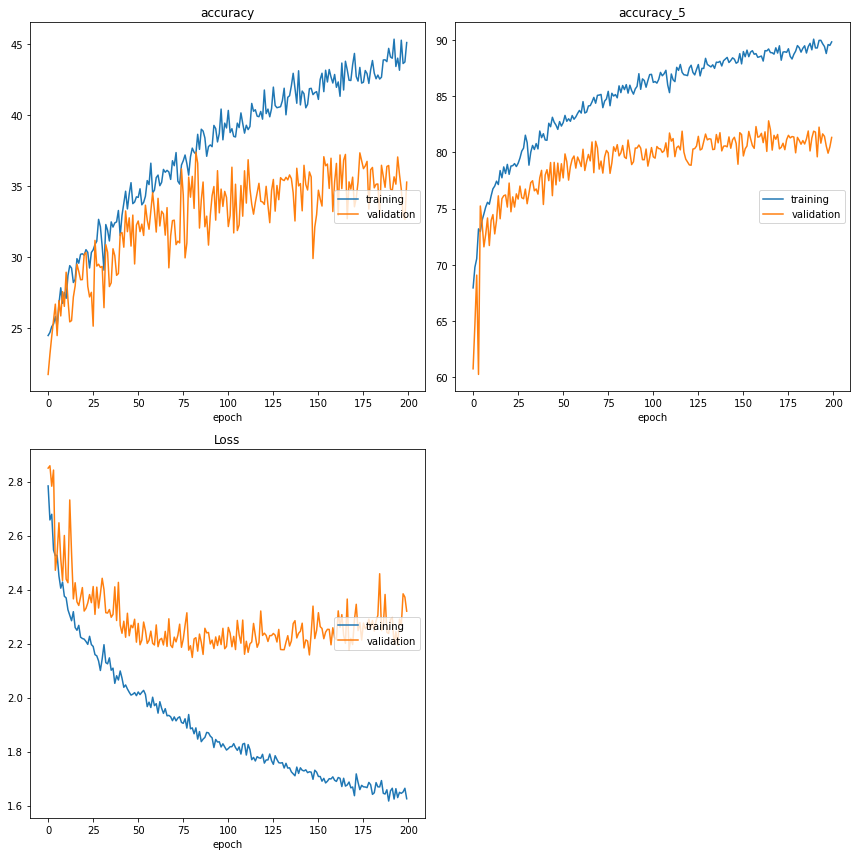

accuracy
	training         	 (min:   24.458, max:   45.368, cur:   45.129)
	validation       	 (min:   21.713, max:   37.398, cur:   35.281)
accuracy_5
	training         	 (min:   67.960, max:   90.068, cur:   89.823)
	validation       	 (min:   60.267, max:   82.808, cur:   81.333)
Loss
	training         	 (min:    1.617, max:    2.784, cur:    1.625)
	validation       	 (min:    2.149, max:    2.859, cur:    2.320)


In [22]:
liveloss = PlotLosses()
for epoch in range(200):
    logs = {}
    
    train_result = classifier.train_step()
    
    epoch_loss = sum(train_result[f'{models[3].frame_count}_loss']) / len(trainloader)
    epoch_acc1 = sum(train_result[f'{models[3].frame_count}_acc1']) / len(trainloader)
    epoch_acc5 = sum(train_result[f'{models[3].frame_count}_acc5']) / len(trainloader)
    
    test_result = classifier.test_step()
    
    epoch_loss_ = sum(test_result[f'{models[3].frame_count}_loss']) / len(testloader)
    epoch_acc1_ = sum(test_result[f'{models[3].frame_count}_acc1']) / len(testloader)
    epoch_acc5_ = sum(test_result[f'{models[3].frame_count}_acc5']) / len(testloader)
    
    logs['loss'] = epoch_loss
    logs['accuracy'] = epoch_acc1
    logs['accuracy_5'] = epoch_acc5
    logs['val_loss'] = epoch_loss_
    logs['val_accuracy'] = epoch_acc1_
    logs['val_accuracy_5'] = epoch_acc5_

    liveloss.update(logs)
    liveloss.send()

In [23]:
class h_mask(object):
    def __init__(self, p: float=0.5):
        self.p = p
        
    def __call__(self, sample):
        x = np.random.choice([0,1], p=[1-self.p, self.p])
        if x:
            

SyntaxError: unexpected EOF while parsing (<ipython-input-23-bce56f9603a8>, line 9)

In [36]:
it = iter(trainloader)
x = it.next()

In [45]:
def _sample_frames(data):
    features = []
    labels = {}
    for feature, label in data:
        video_length = feature.shape[0]
        if video_length < frame_samplers[3].frame_count:
            raise ValueError(f"Video too short to sample {frame_samplers[3].frame_count} from")
        idxs = np.array(frame_idx_to_list(frame_samplers[3].sample(video_length)))
        features.append(feature[idxs])
        for k in label.keys():
            if k in labels:
                labels[k].append(label[k])
            else:
                labels[k] = [label[k]]

    for k in labels.keys():
        try:
            labels[k] = torch.tensor(labels[k])
        except ValueError:
            pass

    return torch.tensor(features, dtype=torch.float), labels

In [46]:
alie = _sample_frames(x)

In [66]:
data, labels = _sample_frames(x)

In [67]:
data

tensor([[[ -4.7028,   7.0160,   1.3524,  ...,  -5.4622,  62.8877,  -3.8441],
         [ -4.8337,   8.5421,   2.8815,  ...,  -5.5607,  61.8090,  -4.0325],
         [ -4.7991,   7.6369,   2.9171,  ...,  -5.4934,  61.0469,  -3.9521],
         [ -4.5849,   8.7491,   1.8933,  ...,  -5.4643,  59.0576,  -3.8343]],

        [[ -5.8763,  10.6428, -20.3478,  ...,  -7.1526,  65.8568,  -5.0250],
         [ -5.2562,  18.9106, -15.7246,  ...,  -6.5095,  58.9448,  -4.4886],
         [ -5.1825,  19.5927, -15.9073,  ...,  -6.4973,  57.4300,  -4.4691],
         [ -5.8751,  19.9454, -21.0092,  ...,  -7.2996,  60.6897,  -4.9820]],

        [[ -3.7806,  16.0529,   3.7001,  ...,  -4.8682,  48.3093,  -3.4146],
         [ -3.7726,  13.6561,  -1.5862,  ...,  -4.8697,  49.1320,  -3.4256],
         [ -3.7685,  13.7954,  -1.5068,  ...,  -4.8680,  49.0924,  -3.4238],
         [ -4.6618,  15.1914,   0.2839,  ...,  -5.9085,  56.7995,  -3.9786]],

        ...,

        [[ -4.0059,   5.4779,  -6.8453,  ...,  -5.1225, 